In [17]:
# Loading libraries
# Data manipulation
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Modeling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, train_test_split, RandomizedSearchCV
from scipy.stats import randint

# Data visualization
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

In [18]:
null_replace = 0.1
data = pd.read_csv('input_ML_Matrix.csv')
print(data.info())  
print(data.isna().sum())
data = data.fillna(null_replace)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14105 entries, 0 to 14104
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sequences  14105 non-null  object 
 1   EvalueQa   14105 non-null  float64
 2    scoreQa   14105 non-null  float64
 3   lengthsQa  14105 non-null  float64
 4   labelsQa   14105 non-null  object 
 5   EvalueQb   14105 non-null  float64
 6    scoreQb   14105 non-null  float64
 7   lengthsQb  14105 non-null  float64
 8   labelsQb   14105 non-null  object 
 9   EvalueQc   14105 non-null  float64
 10   scoreQc   14105 non-null  float64
 11  lengthsQc  14105 non-null  float64
 12  labelsQc   14105 non-null  object 
 13  EvalueR    14105 non-null  float64
 14   scoreR    14105 non-null  float64
 15  lengthsR   14105 non-null  float64
 16  labelsR    14105 non-null  object 
dtypes: float64(12), object(5)
memory usage: 1.8+ MB
None
sequences    0
EvalueQa     0
 scoreQa     0
lengthsQa    0
labelsQa     

In [19]:
# Reorganize the data

def determine_class(row):
    if row['labelsQa'] == 'Qa':
        return 'Qa'
    elif row['labelsQb'] == 'Qb':
        return 'Qb'
    elif row['labelsQc'] == 'Qc':
        return 'Qc'
    elif row['labelsR'] == 'R':
        return 'R'
    else:
        return 'Unknown'
    
data['family'] = data.apply(determine_class, axis=1)
data.drop(['labelsQa', 'labelsQb', 'labelsQc', 'labelsR'], axis=1, inplace=True)
data.to_csv('updated_input_ML_Matrix.csv', index=False)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14105 entries, 0 to 14104
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sequences  14105 non-null  object 
 1   EvalueQa   14105 non-null  float64
 2    scoreQa   14105 non-null  float64
 3   lengthsQa  14105 non-null  float64
 4   EvalueQb   14105 non-null  float64
 5    scoreQb   14105 non-null  float64
 6   lengthsQb  14105 non-null  float64
 7   EvalueQc   14105 non-null  float64
 8    scoreQc   14105 non-null  float64
 9   lengthsQc  14105 non-null  float64
 10  EvalueR    14105 non-null  float64
 11   scoreR    14105 non-null  float64
 12  lengthsR   14105 non-null  float64
 13  family     14105 non-null  object 
dtypes: float64(12), object(2)
memory usage: 1.5+ MB
None


In [20]:
# Coding family column as numerical
le = LabelEncoder()
data['family'] = le.fit_transform(data['family'])
data.to_csv('updated_input_ML_Matrix.csv', index=False)

In [21]:
# Splitting the data into training and testing sets
X = data.drop(['family', 'sequences'], axis=1)
Y = data['family']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [22]:
# Building the model
rf = RandomForestClassifier(n_estimators=100, random_state=42) # n_estimators is the number of trees in the forest 
rf.fit(X_train, Y_train)
y_pred = rf.predict(X_test)
accuracy = accuracy_score(Y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.9996455157745481


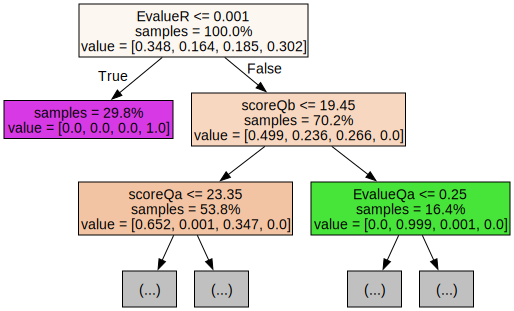

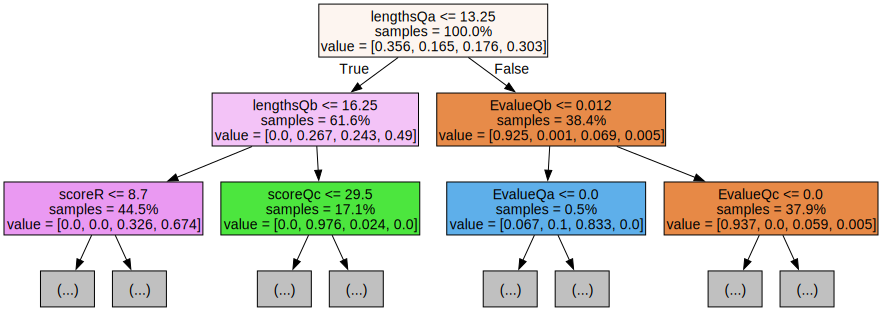

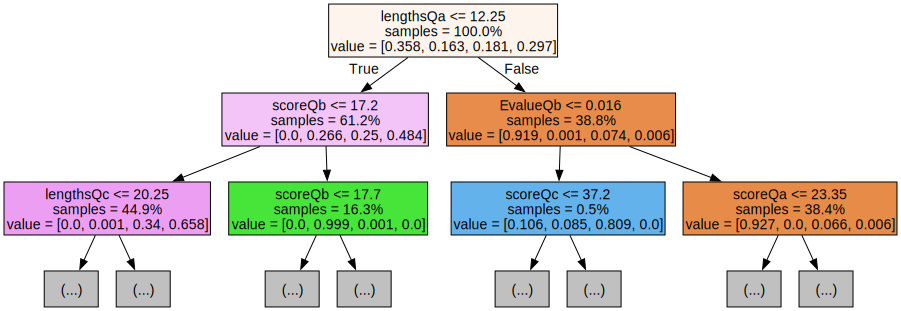

In [23]:
for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

In [24]:
# Hyperparameter tuning
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, Y_train)

# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)



Best hyperparameters: {'max_depth': 11, 'n_estimators': 91}


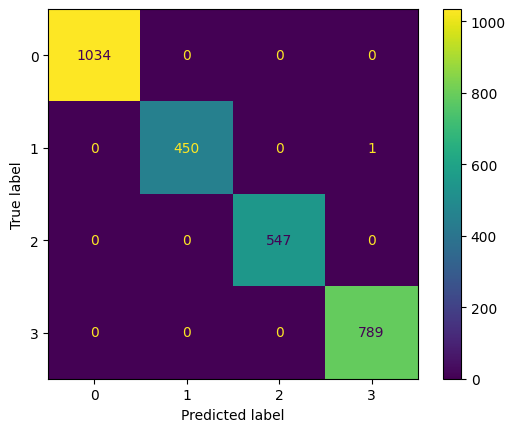

In [25]:
# Generate predictions with the best model
y_pred = best_rf.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(Y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()

<Axes: >

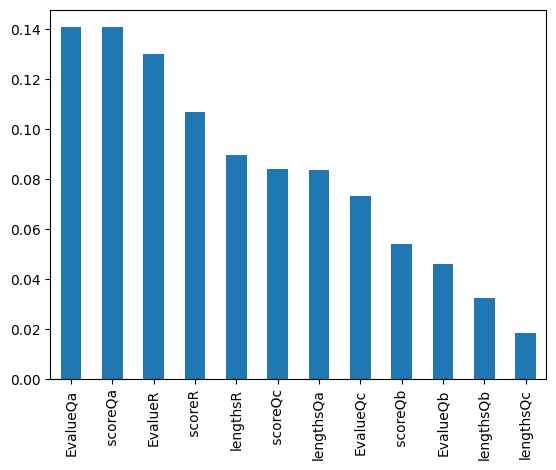

In [27]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar()

In [28]:
accuracy = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred, average='weighted')
recall = recall_score(Y_test, y_pred, average='weighted')
f1 = f1_score(Y_test, y_pred, average='weighted')

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1:', f1)

Accuracy: 0.9996455157745481
Precision: 0.9996459644887574
Recall: 0.9996455157745481
F1: 0.9996454313070382
